Epoch 1/100
94/94 - 3s - loss: 0.0511 - 3s/epoch - 30ms/step
Epoch 2/100
94/94 - 0s - loss: 0.0247 - 185ms/epoch - 2ms/step
Epoch 3/100
94/94 - 0s - loss: 0.0181 - 185ms/epoch - 2ms/step
Epoch 4/100
94/94 - 0s - loss: 0.0160 - 187ms/epoch - 2ms/step
Epoch 5/100
94/94 - 0s - loss: 0.0149 - 205ms/epoch - 2ms/step
Epoch 6/100
94/94 - 0s - loss: 0.0138 - 184ms/epoch - 2ms/step
Epoch 7/100
94/94 - 0s - loss: 0.0128 - 176ms/epoch - 2ms/step
Epoch 8/100
94/94 - 0s - loss: 0.0117 - 165ms/epoch - 2ms/step
Epoch 9/100
94/94 - 0s - loss: 0.0108 - 176ms/epoch - 2ms/step
Epoch 10/100
94/94 - 0s - loss: 0.0097 - 184ms/epoch - 2ms/step
Epoch 11/100
94/94 - 0s - loss: 0.0089 - 178ms/epoch - 2ms/step
Epoch 12/100
94/94 - 0s - loss: 0.0080 - 169ms/epoch - 2ms/step
Epoch 13/100
94/94 - 0s - loss: 0.0072 - 173ms/epoch - 2ms/step
Epoch 14/100
94/94 - 0s - loss: 0.0064 - 180ms/epoch - 2ms/step
Epoch 15/100
94/94 - 0s - loss: 0.0056 - 176ms/epoch - 2ms/step
Epoch 16/100
94/94 - 0s - loss: 0.0049 - 180ms/epoc

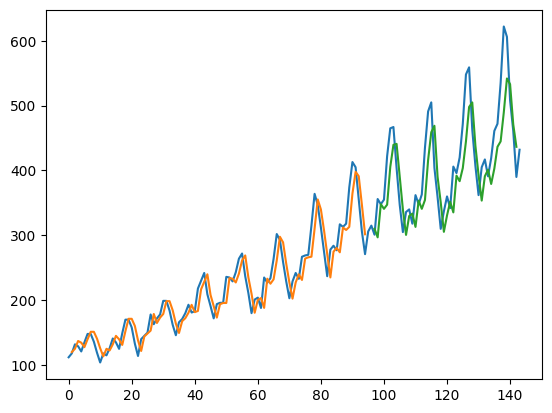

In [8]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Load the dataset
from statsmodels.datasets import get_rdataset
data = get_rdataset('AirPassengers').data
data = data.set_index('time')

# Preprocessing
dataset = data.values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# Reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# Make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# Plot the results
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()



Image Classification Task:

In [9]:
import numpy as np
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split

# Load the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Normalize pixel values to be between 0 and 1
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Reshape data to have a single channel
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Convert labels to one-hot encoding
num_classes = 10
y_train = np.eye(num_classes)[y_train]
y_test = np.eye(num_classes)[y_test]

# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_val, y_val), callbacks=[reduce_lr])

import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Epoch 1/5
844/844 [==============================] - 40s 46ms/step - loss: 0.1848 - accuracy: 0.9448 - val_loss: 0.0766 - val_accuracy: 0.9770
Epoch 2/5
844/844 [==============================] - 39s 46ms/step - loss: 0.0550 - accuracy: 0.9825 - val_loss: 0.0501 - val_accuracy: 0.9863
Epoch 3/5
844/844 [==============================] - 40s 47ms/step - loss: 0.0408 - accuracy: 0.9872 - val_loss: 0.0486 - val_accuracy: 0.9862
Epoch 4/5
844/844 [==============================] - 38s 45ms/step - loss: 0.0292 - accuracy: 0.9909 - val_loss: 0.0384 - val_accuracy: 0.9897
Epoch 5/5
313/313 [==============================] - 2s 8ms/step - loss: 0.0404 - accuracy: 0.9873
Test Accuracy: 98.73%
Epoch 1/5
844/844 [==============================] - 40s 48ms/step - loss: 0.0171 - accuracy: 0.9944 - val_loss: 0.0382 - val_accuracy: 0.9893 - lr: 0.0010
Epoch 2/5
615/844 [====================>.........] - ETA: 10s - loss: 0.0159 - accuracy: 0.9946

KeyboardInterrupt: 